# Nested CV: Pearson r per fold

This notebook loads two result files:
- `outputs/nested_cv/nested_cv_results.json`
- `outputs/nested_cv/nested_cv_nograph_results.json`

It then visualizes the per-fold Pearson correlation for each side by side in the same figure.

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Two result files to compare
a_path = Path('outputs/nested_cv/nested_cv_results.json')
b_path = Path('outputs/nested_cv/nested_cv_nograph_results.json')

if not a_path.exists():
    raise FileNotFoundError(f'Could not find metrics file: {a_path}')
if not b_path.exists():
    raise FileNotFoundError(f'Could not find metrics file: {b_path}')

# Load both
with open(a_path, 'r', encoding='utf-8') as f:
    data_a = json.load(f)
with open(b_path, 'r', encoding='utf-8') as f:
    data_b = json.load(f)

# Robust parser to support multiple formats
# - Format A: {"per_fold": [{"fold": int, "pearson_r": float}, ...], "overall": {"pearson_r": float}}
# - Format B: {"fold_corr": [float, ...], "mean": float, "std": float}

def to_df_and_overall(d: dict):
    per_fold = d.get('per_fold')
    if isinstance(per_fold, list) and per_fold and isinstance(per_fold[0], dict):
        df = pd.DataFrame(per_fold)
        if 'fold' in df.columns:
            df['fold'] = df['fold'].astype(int)
        if 'pearson_r' in df.columns:
            df['pearson_r'] = df['pearson_r'].astype(float)
        overall = d.get('overall', {}).get('pearson_r', None)
        return df, overall

    fold_corr = d.get('fold_corr')
    if isinstance(fold_corr, list) and len(fold_corr) > 0:
        df = pd.DataFrame({
            'fold': np.arange(1, len(fold_corr) + 1, dtype=int),
            'pearson_r': np.array(fold_corr, dtype=float),
        })
        overall = d.get('mean', None)
        return df, overall

    raise ValueError('Unrecognized results format. Expected keys per_fold/overall or fold_corr/mean.')

# Build DataFrames
dfa, overall_a = to_df_and_overall(data_a)
dfb, overall_b = to_df_and_overall(data_b)

# Show heads for sanity
dfa.head(), dfb.head()

(   fold  pearson_r
 0     1   0.397000
 1     2   0.312820
 2     3   0.381136
 3     4   0.349573
 4     5   0.325770,
    fold  pearson_r
 0     1   0.423877
 1     2   0.342268
 2     3   0.427744
 3     4   0.358429
 4     5   0.359538)

C:\Users\Simen\AppData\Local\Temp\ipykernel_51196\3227553091.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(vals_a, vert=True, labels=['with graph'])
C:\Users\Simen\AppData\Local\Temp\ipykernel_51196\3227553091.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(vals_b, vert=True, labels=['no graph'])


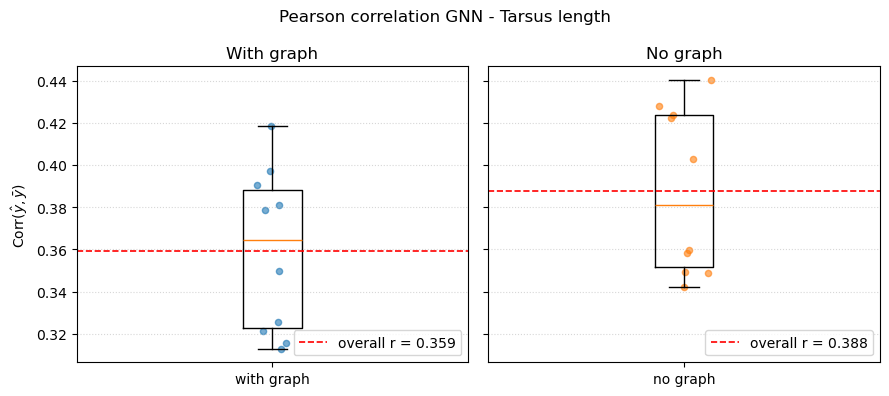

In [6]:
# Boxplots of Pearson r for the two configurations side by side
vals_a = dfa['pearson_r'].values
vals_b = dfb['pearson_r'].values

fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

# Left: with graph (results)
axes[0].boxplot(vals_a, vert=True, labels=['with graph'])
# jitter
x0 = np.random.normal(loc=1, scale=0.03, size=len(vals_a))
axes[0].scatter(x0, vals_a, alpha=0.6, s=20, color='tab:blue')
if overall_a is not None:
    axes[0].axhline(overall_a, color='red', linestyle='--', linewidth=1.2, label=f'overall r = {overall_a:.3f}')
axes[0].set_title('With graph')
# y label in latex (Cor(\haty,\bary))
axes[0].set_ylabel(r'Corr$(\hat{y}, \bar{y})$')
axes[0].grid(axis='y', linestyle=':', alpha=0.5)
axes[0].legend(loc='lower right')

# Right: no graph
axes[1].boxplot(vals_b, vert=True, labels=['no graph'])
# jitter
x1 = np.random.normal(loc=1, scale=0.03, size=len(vals_b))
axes[1].scatter(x1, vals_b, alpha=0.6, s=20, color='tab:orange')
if overall_b is not None:
    axes[1].axhline(overall_b, color='red', linestyle='--', linewidth=1.2, label=f'overall r = {overall_b:.3f}')
axes[1].set_title('No graph')
axes[1].grid(axis='y', linestyle=':', alpha=0.5)
axes[1].legend(loc='lower right')

fig.suptitle('Pearson correlation GNN - Tarsus length')
plt.tight_layout()
plt.show()